# Introduction to LangGraph & State Management

In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
import os

print("All libraries imported!")

All libraries imported!


In [21]:
load_dotenv()
api_key = os.getenv("paid_api")

if not api_key:
    raise ValueError("API Key not found!")
print("API Key loaded successfully")

API Key loaded successfully


In [22]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0.7,
    api_key=api_key
)

print(f"LLM initialized {llm.model_name}")

LLM initialized gpt-4o-mini


## State

State is the data that flows through the graph<br>
MessagesState: stores conversation history<br>

Nodes processes the state and return updates, they are defined the way functions are defined<br>

Edges are connections between nodes that control the flow of the agent. They include static and conditional edges, conditional edges are dynamic and enable decision making<br>

Checkpointer gives the agent memory by saving the state between interactions

### The Assistant Node

In [23]:
# A node that send messages to the LLM and gets a response
sys_msg = SystemMessage(
    content= "You are a friendly assistant that answers user question. Be helpful and concise."
)

def assistant(state: MessagesState) -> dict: #state expect an input in the form of MessagesState, and gives a dictionary as the output
    """
    The assistant node - processes messages and generates response.
    """
    #Combines system prompt with conversation history
    messages = [sys_msg] + state["messages"] #MessagesState contains a dictionary of list with messages as the key

    #Get response from LLM
    response = llm.invoke(messages)
    #Return as state update
    return {messages: [AIMessage(content=response.content)]}

print("Assistant mode defined")

Assistant mode defined


## Building the Graph

In [24]:
#Create a StateGraph with MessagesState
builder = StateGraph(MessagesState)
#Adding teh assistant node
builder.add_node("assistant", assistant)

#Define the flow:
# START -> assitant -> END
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

print("Graph structure defined")

Graph structure defined


### Checkpointers Memory

In [25]:
#Create a memory checkpointer
memory = MemorySaver()

#Compile graph with memory
agent = builder.compile(checkpointer=memory)
print("Agent compiled with memory")

Agent compiled with memory


### Visualizing the Graph

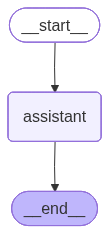

In [26]:
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: Start -> assistant -> END")

### Running the Agent

Messages with the same session ids/ thread ids share memory

In [27]:
# Defining a session id for the conversation
session_id = "chat_session_0012"
print(f"Starting conversation with session ID: {session_id}")

Starting conversation with session ID: chat_session_0012


#### Helper function for Conversation

In [28]:
def run_conversation(user_input: str, thread_id: str=session_id):
    """
    Send a message to the agent and get response.
    WARNING: Using default thread_id shares conversation acrosss all calls!
    In production, ALWAYS provide unique thread_id per user.
    """
    #Invoke the agent
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    # Print the conversation
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"Agent: {message.content}")
    print("\n"+ "="*70)

print("Conversation function ready")

Conversation function ready


In [29]:
run_conversation("Hello! What is your name?")

TypeError: unhashable type: 'list'